In [19]:
## Load packages ##

import requests
import json
import time
import pandas as pd
import numpy as np
import covalent_api as c
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from pandas.plotting import lag_plot
import datetime
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import accuracy_score, r2_score, precision_score
from PIL import Image
import requests
from io import BytesIO
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from math import sqrt

In [20]:
## Load functions ##

def fetch_collection_hist(address):
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/nft_market/collection/{address}/'
    url = api_url + endpoint
    r = requests.get(url, auth=('ckey_e9bfb5c526384e90a9c1d53d154',''))#change the API authentication key if you want to use different api(the api request takes uptp 45 mins to process depending on the size of the data)
    input_data = r.json()
    print(input_data)
    input_data = input_data['data']['items']
    out = pd.DataFrame.from_records(input_data)
    return(out)

def fetch_token_id(address): 
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/tokens/{address}/nft_token_ids/'
    url = api_url + endpoint
    r = requests.get(url, auth=('ckey_e9bfb5c526384e90a9c1d53d154',''))
    input_data = r.json()
    return(input_data)

def fetch_token_tx(address, token_id):
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/tokens/{address}/nft_transactions/{token_id}/'
    url = api_url + endpoint
    r = requests.get(url, auth=('ckey_e9bfb5c526384e90a9c1d53d154',''))
    input_data = r.json()
    return(input_data)

def fetch_token_meta(address, token_id):
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/tokens/{address}/nft_metadata/{token_id}/'
    url = api_url + endpoint
    r = requests.get(url, auth=('ckey_e9bfb5c526384e90a9c1d53d154',''))
    input_data = r.json()
    input_data = input_data['data']['items'][0]['nft_data']
    out = pd.DataFrame.from_records(input_data)
    out_2 = pd.DataFrame.from_records(out['external_data'])
    out_table = pd.DataFrame({'token_id': out['token_id']
                              ,'token_balance': out['token_balance']
                              ,'image_url': out_2['image']
                              ,'traits': out_2['attributes']})

    trait = pd.DataFrame.from_records(out_table['traits'][0])
    trait.loc[:,'token_id'] = out_table['token_id']
    trait['token_id'] = out_table['token_id'].tolist() * len(trait)
    trait['image_url'] = out_table['image_url'].tolist() * len(trait)            
    return(trait)

def stationary_test(x):
    out = adfuller(x.dropna())
    print('ADF Statistic: %f' % out[0])
    print('p-value: %f' % out[1])
    if out[1] <= 0.05:
        print('Time-series is stationary at 5% significance level.')
    else:
        print('Time-series is non-stationary at 5% significance level. Find the order of difference!')

# Accuracy metrics
def accuracy(y_hat, y):
    mape = np.mean(np.abs(y_hat - y)/np.abs(y))     
    rmse = np.mean((y_hat - y)**2)**0.5
    corr = np.corrcoef(y_hat, y)[0,1]   

    return({'Mean absolute percentage error':mape
            , 'Root mean squared error':rmse
            , 'corr':corr})

{'data': {'updated_at': '2022-11-27T17:48:30.524639293Z', 'items': [{'chain_id': 1, 'collection_name': 'Cool Cats', 'collection_address': '0x1a92f7381b9f03921564a437210bb9396471050c', 'collection_ticker_symbol': 'COOL', 'opening_date': '2022-04-06', 'volume_wei_day': '118750000000000000000', 'volume_quote_day': 397669.1, 'average_volume_wei_day': '9134615384615390000', 'average_volume_quote_day': 30589.932, 'unique_token_ids_sold_count_day': 11, 'floor_price_wei_7d': '11518835732903000000', 'floor_price_quote_7d': 38574.19, 'gas_quote_rate_day': 3348.7925, 'quote_currency': 'USD', 'first_nft_image_token_id': None, 'first_nft_image': None, 'first_nft_image_256': None, 'first_nft_image_512': None, 'first_nft_image_1024': None, 'second_nft_image_token_id': '1', 'second_nft_image': 'https://ipfs.io/ipfs/QmYrxAviWHGugdikgU1Awc8MRtfqxMYYRmBuCTMEc5mCAx', 'second_nft_image_256': 'https://image-proxy.svc.prod.covalenthq.com/cdn-cgi/image/width=256,fit/https://ipfs.io/ipfs/QmYrxAviWHGugdikgU1Awc

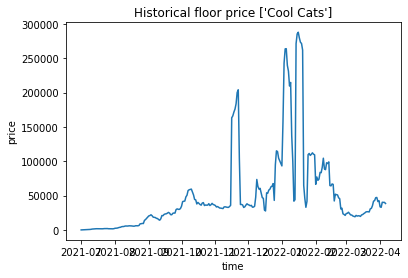

In [26]:
## ༼ つ ◕_◕ ༽つ Input NFT contract address below: 

## (BAYC as an example here)
nft_address = '0x1a92f7381b9f03921564a437210bb9396471050c'
# for mayc:0x60E4d786628Fea6478F785A6d7e704777c86a7c6
# for bayc:0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
# https://etherscan.io/address/0x1a92f7381b9f03921564a437210bb9396471050c check for smart contract addresses

## Read in historic floor prices ##

## Read in floor price 
data = fetch_collection_hist(nft_address)
data['opening_date'] = pd.to_datetime(data['opening_date'])
data = data.sort_values(by='opening_date', ascending=True)
data.set_index('opening_date', inplace=True)

## Plot floor price
name = np.unique(data['collection_name']).tolist()
plt.plot( data["floor_price_quote_7d"])
plt.title("Historical floor price "+str(name))
plt.xlabel("time")
plt.ylabel("price")
plt.show()

0       The body is: blue cat skin
1      The hats is: bucket hat tan
2      The shirt is: overalls blue
3    The face is: sunglasses pixel
4              The tier is: cool_2
dtype: object


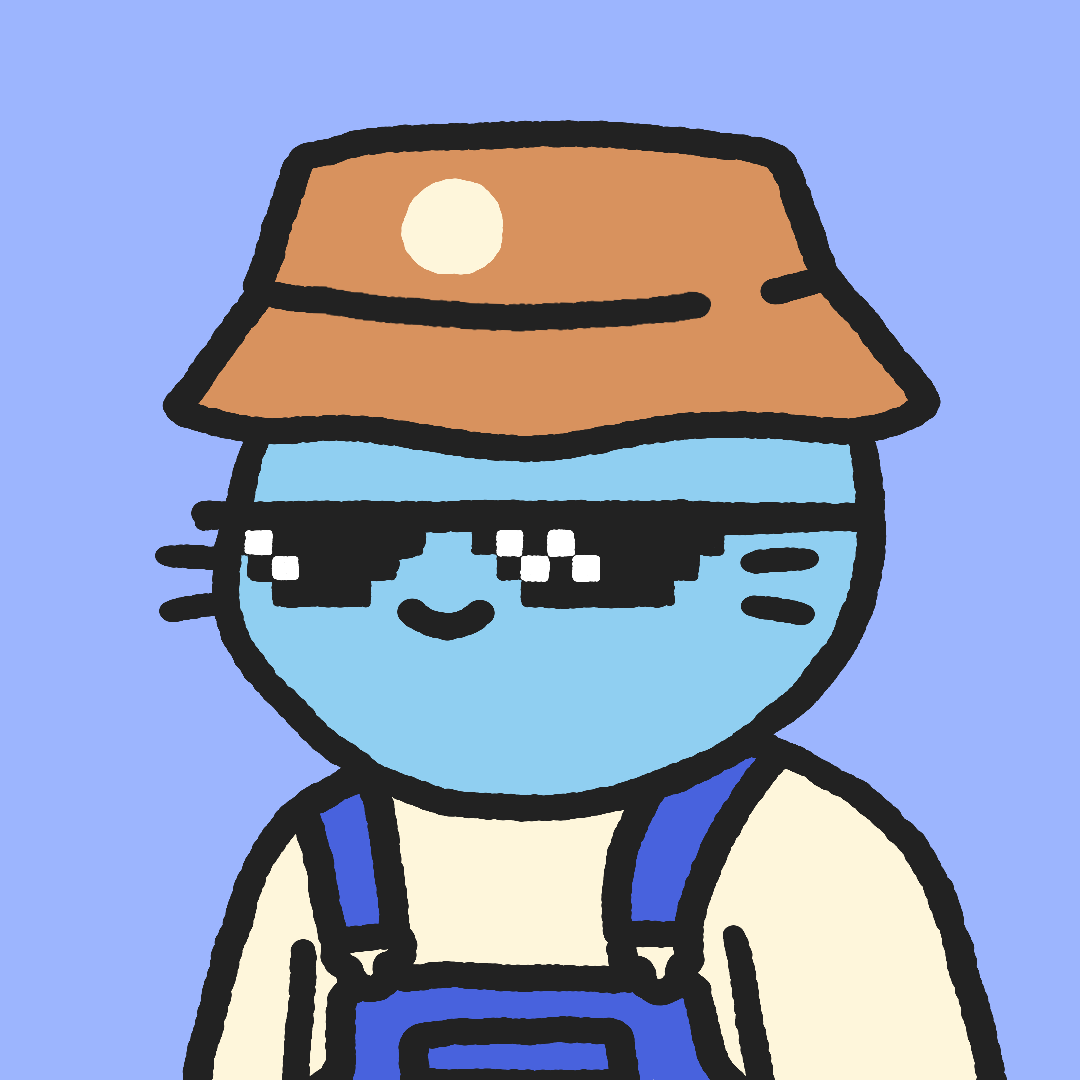

In [59]:
## Input a token ID below:

tokenId = '90'

## Display the NFT & its traits
token_meta = fetch_token_meta(nft_address, tokenId)
print("The "+token_meta["trait_type"]+" is: "+token_meta["value"])
url = token_meta['image_url'][0]
response = requests.get(url)
Image.open(BytesIO(response.content))

c:\Users\Chaitanya\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


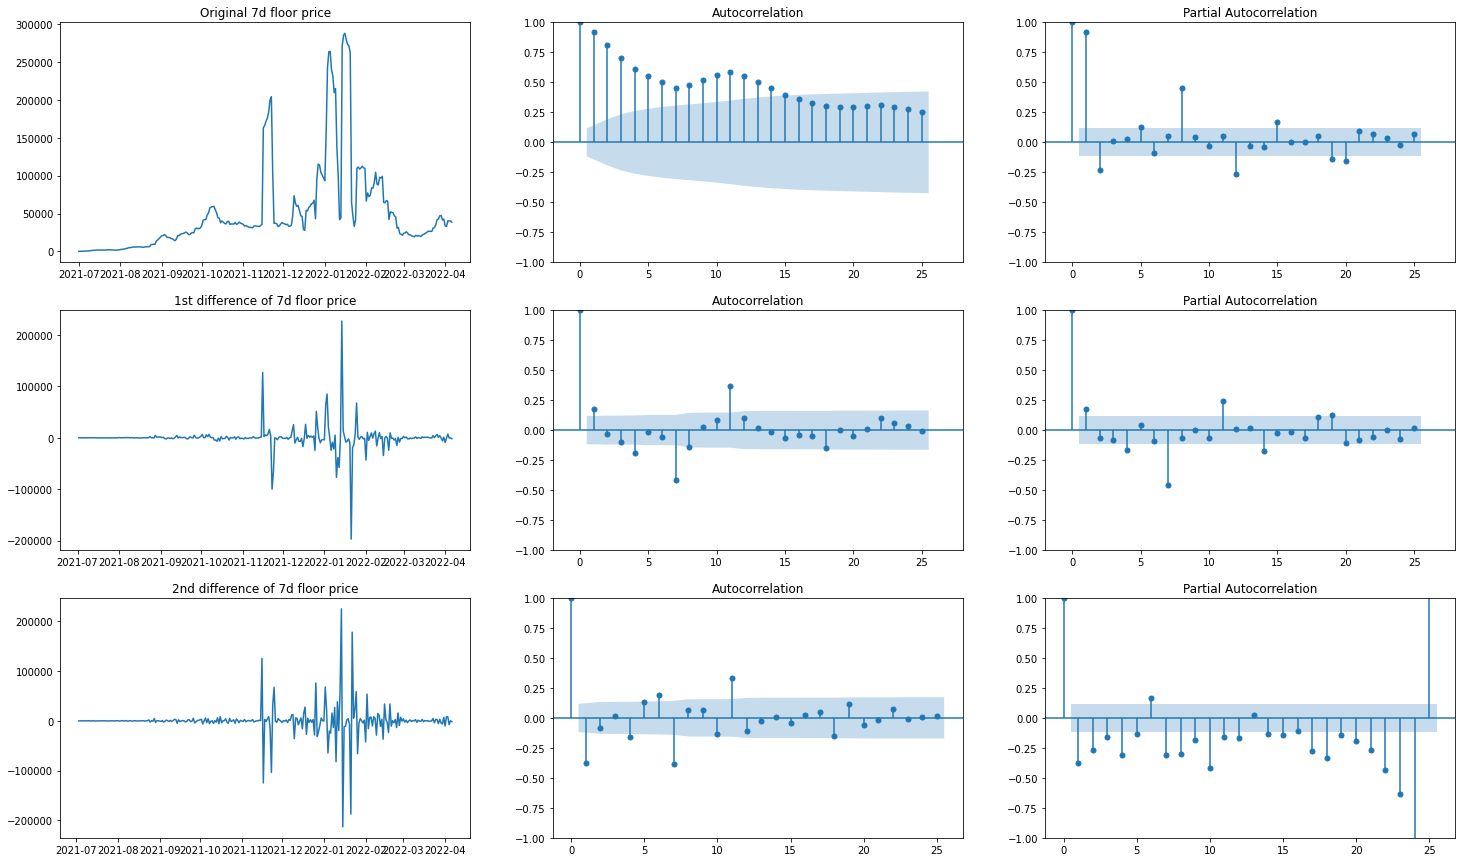

In [60]:
## Plot floor price & its differences ##

## Original floor price
fig, axes = plt.subplots(3, 3, sharex=False, figsize=(25,15))
diff0 = data['floor_price_quote_7d']
axes[0,0].plot(diff0); axes[0, 0].set_title('Original 7d floor price')
plot_acf(diff0.dropna(), ax=axes[0, 1])
axes[0,1].axis(xmin=-2, xmax=28)
plot_pacf(diff0.dropna(), ax=axes[0, 2])
axes[0,2].axis(xmin=-2, xmax=28)

## 1st diff
diff1 = data['floor_price_quote_7d'].diff()
axes[1,0].plot(diff1); axes[1, 0].set_title('1st difference of 7d floor price')
plot_acf(diff1.dropna(), ax=axes[1, 1])
axes[1,1].axis(xmin=-2, xmax=28)
plot_pacf(diff1.dropna(), ax=axes[1, 2])
axes[1,2].axis(xmin=-2, xmax=28)

## 2nd diff
## lag goes too far negative => over-differenced!
diff2 = data['floor_price_quote_7d'].diff().diff()
axes[2,0].plot(diff2); axes[2, 0].set_title('2nd difference of 7d floor price')
plot_acf(diff2.dropna(), ax=axes[2, 1])
plot_pacf(diff2.dropna(), ax=axes[2, 2])
plt.show()

In [61]:
## Stationarity Tests
stationary_test(diff0) ## non-stationary
stationary_test(diff1) ## stationary
stationary_test(diff2)

ADF Statistic: -2.119959
p-value: 0.236565
Time-series is non-stationary at 5% significance level. Find the order of difference!
ADF Statistic: -5.499733
p-value: 0.000002
Time-series is stationary at 5% significance level.
ADF Statistic: -7.803186
p-value: 0.000000
Time-series is stationary at 5% significance level.


In [62]:
## Training testing split ##
train_size = round(len(data)*0.8)

train = data.floor_price_quote_7d[:train_size]
test = data.floor_price_quote_7d[train_size:]
print(train)

opening_date
2021-07-01        73.63581
2021-07-02       145.43475
2021-07-03       148.71074
2021-07-04       234.94214
2021-07-05       253.67885
                  ...     
2022-02-05     83883.42000
2022-02-06     83401.99000
2022-02-07     91426.36000
2022-02-08    104512.31000
2022-02-09     88761.22000
Name: floor_price_quote_7d, Length: 224, dtype: float64


# Linear Regression

In [72]:
df=pd.DataFrame(list(data.floor_price_quote_7d[:]))
df.index=data.floor_price_quote_7d[:].index
df.columns=["Sales"]
# df.plot(figsize=(12,8))
df["Sale_yesterday"]=df["Sales"].shift(+1)
df["Sale_2daysback"]=df["Sales"].shift(+2)
df["Sale_3daysback"]=df["Sales"].shift(+3)
df=df.dropna()
# df.set_index(data.index)

In [73]:
lin_model=LinearRegression()
import numpy as np
x1,x2,x3,y=df['Sale_yesterday'],df['Sale_2daysback'],df['Sale_3daysback'],df['Sales']
x1,x2,x3,y=np.array(x1),np.array(x2),np.array(x3),np.array(y)
x1,x2,x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3),axis=1)
print(final_x)

[[1.48710740e+02 1.45434750e+02 7.36358100e+01]
 [2.34942140e+02 1.48710740e+02 1.45434750e+02]
 [2.53678850e+02 2.34942140e+02 1.48710740e+02]
 [2.80650100e+02 2.53678850e+02 2.34942140e+02]
 [5.61717100e+02 2.80650100e+02 2.53678850e+02]
 [5.90893200e+02 5.61717100e+02 2.80650100e+02]
 [7.69730900e+02 5.90893200e+02 5.61717100e+02]
 [9.33107540e+02 7.69730900e+02 5.90893200e+02]
 [1.29593710e+03 9.33107540e+02 7.69730900e+02]
 [1.43261450e+03 1.29593710e+03 9.33107540e+02]
 [1.47431430e+03 1.43261450e+03 1.29593710e+03]
 [1.79351450e+03 1.47431430e+03 1.43261450e+03]
 [1.81465930e+03 1.79351450e+03 1.47431430e+03]
 [1.76023550e+03 1.81465930e+03 1.79351450e+03]
 [1.74222660e+03 1.76023550e+03 1.81465930e+03]
 [1.66603970e+03 1.74222660e+03 1.76023550e+03]
 [1.70657710e+03 1.66603970e+03 1.74222660e+03]
 [1.70051670e+03 1.70657710e+03 1.66603970e+03]
 [1.72971020e+03 1.70051670e+03 1.70657710e+03]
 [1.97553500e+03 1.72971020e+03 1.70051670e+03]
 [2.04593380e+03 1.97553500e+03 1.729710

In [74]:
X_train,X_test,y_train,y_test=final_x[:-30],final_x[-30:],y[:-30],y[-30:]

In [75]:
lin_model.fit(X_train,y_train)

LinearRegression()

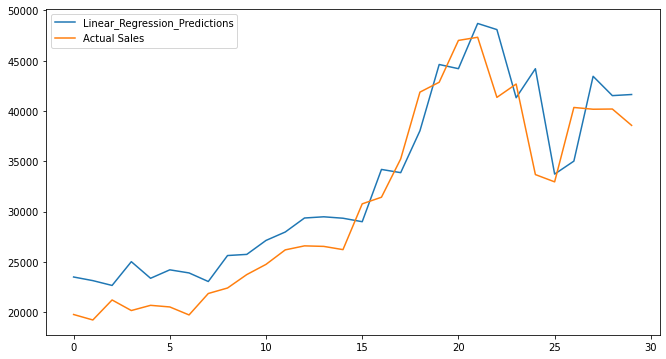

In [76]:
lin_pred=lin_model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(lin_pred,label='Linear_Regression_Predictions')
plt.plot(y_test,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

# Linear regression evaluation metrics

In [82]:
rmse_lr=sqrt(mean_squared_error(lin_pred,y_test))
print('Mean Squared Error for Linear Regression Model is:',rmse_lr)
print(mean_squared_error(lin_pred,y_test))

Mean Squared Error for Linear Regression Model is: 3619.364498904301
13099799.37592878


# Random Forest Regresssor

In [83]:
model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

In [84]:
model.fit(X_train,y_train)

C:\Users\Chaitanya\AppData\Local\Temp\ipykernel_26424\2721349307.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


RandomForestRegressor(max_features=3, random_state=1)

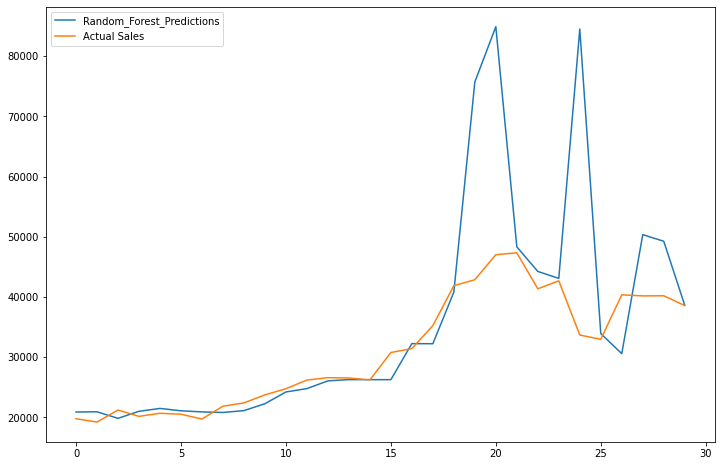

In [85]:
pred=model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

# Random forest evaluation metrics

In [86]:
rmse_rf=sqrt(mean_squared_error(pred,y_test))
print(mean_squared_error(lin_pred,y_test))
print('Root Mean Squared Error for Random Forest Model is:',rmse_rf)

13099799.37592878
Root Mean Squared Error for Random Forest Model is: 13456.886304648757


# XGBoost

In [41]:
df

,Sales,Sale_yesterday,Sale_2daysback,Sale_3daysback
opening_date,,,,
2021-07-04,234.94214,148.71074,145.43475,73.63581
2021-07-05,253.67885,234.94214,148.71074,145.43475
2021-07-06,280.65010,253.67885,234.94214,148.71074
2021-07-07,561.71710,280.65010,253.67885,234.94214
2021-07-08,590.89320,561.71710,280.65010,253.67885
...,...,...,...,...
2022-04-02,32961.12500,33683.23000,42681.70000,41357.24200
2022-04-03,40353.31600,32961.12500,33683.23000,42681.70000
2022-04-04,40178.59000,40353.31600,32961.12500,33683.23000


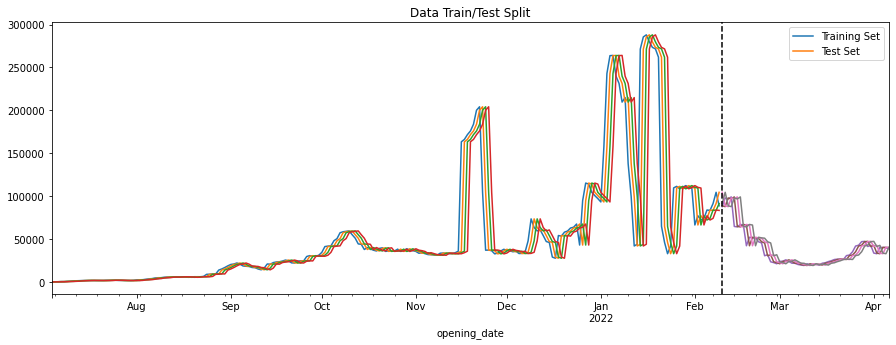

In [42]:
df.index=pd.to_datetime(df.index)
color_pal = sns.color_palette()
train_xg = df.loc[df.index < '2022-02-10']
test_xg = df.loc[df.index >= '2022-02-10']

fig, ax = plt.subplots(figsize=(15, 5))
train_xg.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_xg.plot(ax=ax, label='Test Set')
ax.axvline('2022-02-10', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [43]:
FEATURES = ['Sale_yesterday', 'Sale_2daysback', 'Sale_3daysback']
TARGET = ['Sales']
X_train = train_xg[FEATURES]
y_train = train_xg[TARGET]

X_test = test_xg[FEATURES]
y_test = test_xg[TARGET]

In [44]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[23:18:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:85088.00228	validation_1-rmse:43030.59857
[100]	validation_0-rmse:39195.98445	validation_1-rmse:14425.19176
[200]	validation_0-rmse:23383.16301	validation_1-rmse:9717.80631
[236]	validation_0-rmse:20594.52071	validation_1-rmse:10512.10836


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

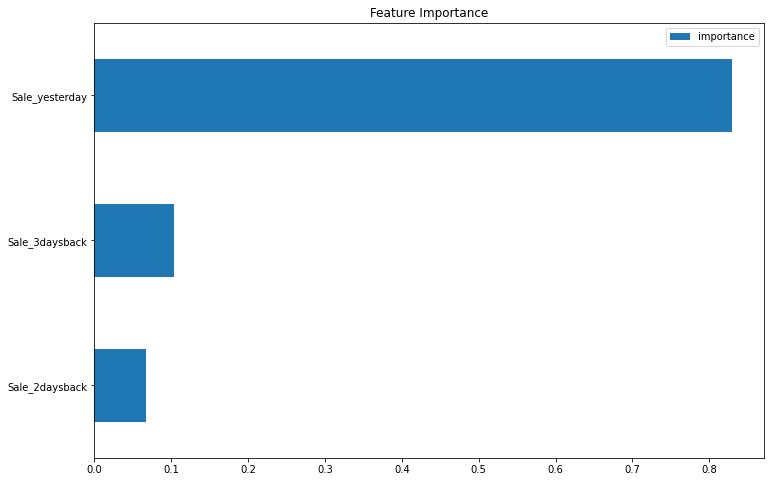

In [45]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [46]:
result=reg.predict((X_test))

                  Sales  Sale_yesterday  Sale_2daysback  Sale_3daysback  \
opening_date                                                              
2022-02-10    87819.930       88761.220      104512.310       91426.360   
2022-02-11    97893.290       87819.930       88761.220      104512.310   
2022-02-12    96764.890       97893.290       87819.930       88761.220   
2022-02-13    99143.250       96764.890       97893.290       87819.930   
2022-02-14    64728.023       99143.250       96764.890       97893.290   
2022-02-15    64212.668       64728.023       99143.250       96764.890   
2022-02-16    67053.090       64212.668       64728.023       99143.250   
2022-02-17    66355.510       67053.090       64212.668       64728.023   
2022-02-18    42237.390       66355.510       67053.090       64212.668   
2022-02-19    52122.273       42237.390       66355.510       67053.090   
2022-02-20    51397.934       52122.273       42237.390       66355.510   
2022-02-21    51045.188  

C:\Users\Chaitanya\AppData\Local\Temp\ipykernel_26424\4265307988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_xg['prediction'] = result


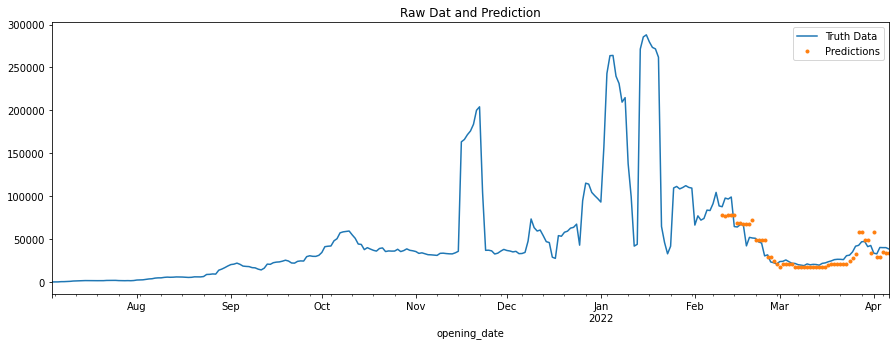

In [47]:
test_xg['prediction'] = result
print(test_xg)
df = df.merge(test_xg[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Sales']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

# XGBoost Evaluation metrics

In [87]:
score = np.sqrt(mean_squared_error(test_xg['Sales'], test_xg['prediction']))
print(mean_squared_error(test_xg['Sales'], test_xg['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

92708487.1030445
RMSE Score on Test set: 9628.52


# Arima model 

In [49]:
## Finding optimal parameters ##
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, 
                      # m=1,             
                      d=None,           
                      seasonal=False,   
                      trace=True, 
                      suppress_warnings=True, 
                      stepwise=True,
                      random_state=123)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5195.485, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5723.986, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5203.617, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5564.807, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5197.409, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5197.556, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5510.830, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5195.573, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5199.474, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5191.668, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5459.745, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5201.267, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5193.077, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5193.387, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept

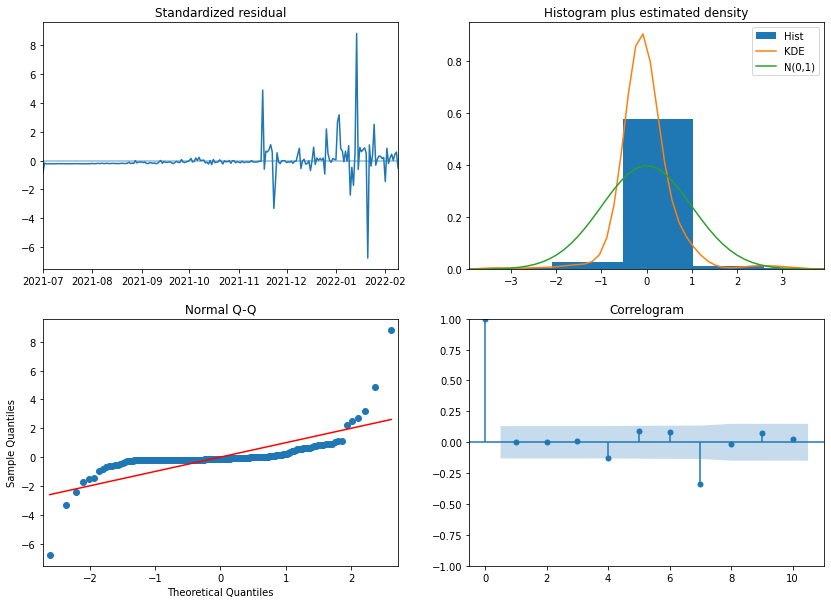

In [50]:
## Check residuals
model.plot_diagnostics(figsize=(14,10))
plt.show()

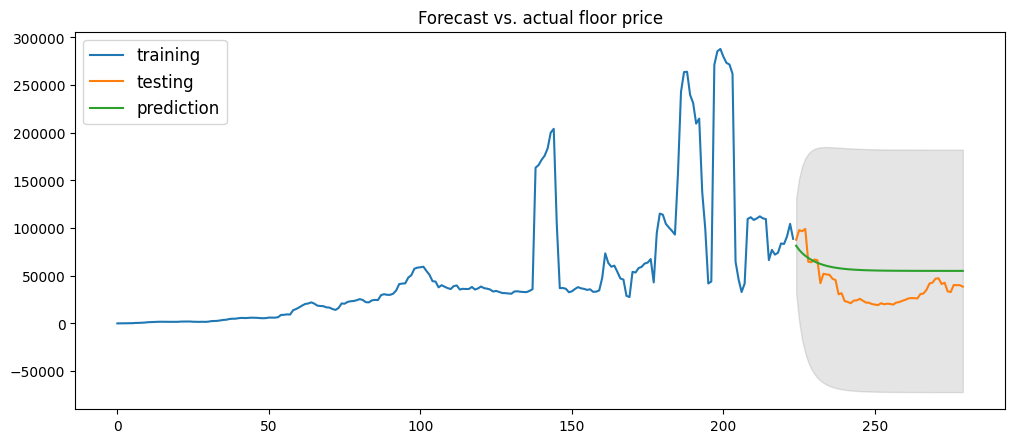

In [51]:
## Prediction ##

pred, ci = model.predict(n_periods = len(test), return_conf_int=True)
idx = np.arange(len(train), len(train) + len(test))

test_pred = pd.Series(pred.values, index = idx)
lb = pd.Series(ci[:, 0], index = idx)
ub = pd.Series(ci[:, 1], index = idx)

# Plot
plot_train = train.reset_index()
plot_test = pd.DataFrame(test).set_index(idx)
plot_pred = pd.DataFrame(test_pred).set_index(idx)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(plot_train.floor_price_quote_7d, label = "training")
plt.plot(plot_test.floor_price_quote_7d, label = "testing")
plt.plot(plot_pred, label = "prediction")
plt.fill_between(lb.index, lb, ub, color='k', alpha = 0.1)
plt.legend(loc='upper left', fontsize = 12)
plt.title("Forecast vs. actual floor price")
plt.show()

# Arima Evaluation Metrics

In [90]:
## Performance metrics
actual = pd.DataFrame(test).reset_index()
actual.columns = ['date','actual']

predict = pd.DataFrame(test_pred).reset_index()
predict.columns = ['date','predict']
accuracy(predict['predict'], actual['actual'])
print(mean_squared_error(test,test_pred))
print(np.sqrt(mean_squared_error(test,test_pred)))

637977159.4673918
25258.209743910826
